# Twitter

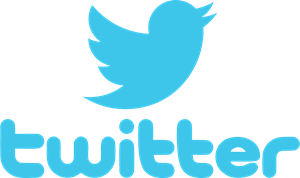

Twitter API allows to fetch live tweets by keyword, or to fetch a 1/6th sample of all twitter traffic.

### Setting up Twitter Credentials

* go to https://apps.twitter.com/
* Apply for a (personal) twitter developer account
* Create a new project
* "Keys and Access Tokens"
* save four keys into `.env` file (or copy `sample.env` to `.env` first)
    * `CONSUMER_KEY` = Consumer Key (API Key)
    * `CONSUMER_SECRET` = Consumer Secret (API Secret)
    * `TWITTER_TOKEN` = Access Token
    * `TWITTER_SECRET` = Access Token Secret

### Getting Started

In [4]:
import os

from dotenv import load_dotenv
load_dotenv()

CONSUMER_KEY = os.environ['CONSUMER_KEY']
CONSUMER_SECRET = os.environ['CONSUMER_SECRET']
TWITTER_TOKEN = os.environ['TWITTER_TOKEN']
TWITTER_SECRET = os.environ['TWITTER_SECRET']

In [5]:
import re

import twitter

# create new twitter stream
stream = twitter.TwitterStream(
    timeout=240,
    heartbeat_timeout=3600,
    auth=twitter.OAuth(TWITTER_TOKEN,
                       TWITTER_SECRET,
                       CONSUMER_KEY,
                       CONSUMER_SECRET))

def get_tweets(terms):
    """
    stream all tweets (within 1/6th quota) indefinitely that contain any of the `terms`.
    
    `statuses.filter` doesn't always return correct matches, so we have to double-check ;)
    """
    # NOTE: using weird syntax instead of '\b' for non-word-boundaries (i.e. starting with '#')
    rex = re.compile(
        r'(?:^|[\W\D]|$)(?:%s)(?:^|[\W\D]|$)' % ('|'.join(re.escape(k) for k in terms),),
        flags=re.I)
    track = ','.join(terms)
    
    for tweet in stream.statuses.filter(track=track):
        text = tweet.get('extended_tweet', {}).get('full_text') or tweet.get('text')
        if tweet.get('lang') == 'en' and rex.search(text):
            yield tweet

### Tweet Filtering

We are looking for all current live tweets that contain the following keywords.
Let's see how long it will take to fetch 10 live tweets?

In [6]:
from itertools import islice

from tqdm import tqdm_notebook

terms = [
    '#BigData',
    '#MachineLearning',
    'machine learning',
    'deep learning',
    'artificial intelligence',
    'data science',
    '#ml',
    '#deeplearning',
    '#datascience',
    '#machinelearning',
    'natural language processing'
]

    
res = tqdm_notebook(get_tweets(terms))
res = list(islice(res, 10))

# Note: figure out how to close stream after use to prevent "Enhance your Calm" error
del stream

### Tweet Structure

A tweet contains a lot of data and metadata:

In [4]:
import json

print(json.dumps(res[0], indent=4))

{
    "created_at": "Wed Feb 19 13:45:24 +0000 2020",
    "id": 1230126237596692485,
    "id_str": "1230126237596692485",
    "text": "RT @AFP: #BREAKING EU rules to demand 'responsible, human-centric' artificial intelligence https://t.co/5prjAhNaO3",
    "source": "<a href=\"https://mobile.twitter.com\" rel=\"nofollow\">Twitter Web App</a>",
    "truncated": false,
    "in_reply_to_status_id": null,
    "in_reply_to_status_id_str": null,
    "in_reply_to_user_id": null,
    "in_reply_to_user_id_str": null,
    "in_reply_to_screen_name": null,
    "user": {
        "id": 1224497611719237633,
        "id_str": "1224497611719237633",
        "name": "Vaclav Pater",
        "screen_name": "PaterVaclav",
        "location": null,
        "url": null,
        "description": "Trader, thinker, talker. Reponomics conossieur and conspiracy nut persona. One man neutral intelligence agency. In it for the humanity. Long/short $ES_F $GOLD",
        "translator_type": "none",
        "protected": fa

### Matched Tweets

Let's look at some of the tweet texts we have captured:

In [5]:
import json
import pandas as pd
pd.options.display.max_colwidth = 280


def prep_tweets(tweets):
    """
    extract fields of interests from tweets
    """
    for tweet in tweets:
        yield {
            'text': tweet.get('extended_tweet', {}).get('full_text') or tweet.get('text'),
            'author': tweet.get('user', {}).get('screen_name'),
            #'lang': tweet.get('lang'),
            # 'urls': [x.get('expanded_url') or x.get('url') for x in tweet.get('entities', {}).get('urls')]
        }

        
prepped = list(prep_tweets(res))
pd.DataFrame(prepped)

,author,text
0,PaterVaclav,"RT @AFP: #BREAKING EU rules to demand 'responsible, human-centric' artificial intelligence https://t.co/5prjAhNaO3"
1,_reactdev,"RT @gp_pulipaka: The Power of Computer Image Recognition, Waldo Has No Chance of Hiding HT @alvinfoo. #BigData #Analytics #DataScience #AI…"
2,into_AI,NantOmics and NantHealth Announce Results of Proprietary Machine Vision AI Software - https://t.co/z4zupjGHkZ #deeplearning #intoAInews
3,TechnoNBusiness,RT @Fisher85M: The Four New Rules of Digital Business {Infographic}\n\n#IoT #bigdata #fintech #sales #APIs #blockchain #Martech #SupplyChain…
4,into_AI,In Praise Of Boring AI (AKA Machine Learning) - With the coming of age of mach https://t.co/USkWLNLpsv #deeplearning #intoAInews
5,mongoosepvt,"RT @gp_pulipaka: The Power of Computer Image Recognition, Waldo Has No Chance of Hiding HT @alvinfoo. #BigData #Analytics #DataScience #AI…"
6,into_AI,"Nvidia Q4 2020: Strong Datacentre Growth, But Virus Concerns Loom - And the way that AI https://t.co/C2cYmUwj21 #deeplearning #intoAInews"
7,StellaYeahilike,"RT @rnalytics: Apple acquires https://t.co/rm3ocPBdUi, an artificial intelligence company in Seattle Apple has acquired an AI-focused start…"
8,into_AI,"Deep Learning Market 2020 2023: Leading Growth Drivers, Emerging Audience, Global - https://t.co/bCSsZMoB2S #deeplearning #intoAInews"
9,Pierre018,"RT @evankirstel: ""Artificial intelligence should serve people,"" says Volkmar Denner, Bosch CEO, at #BCW20 on the Bosch AI code of ethics, g…"


### Hashtags

Find which hashtags occur most frequently in our matched tweets

In [6]:
import gzip
import json
from collections import Counter
import pandas as pd


def get_tweets_from_file():
    """
    load matched tweets from file
    """
    with gzip.open('data/machine_learning-2018-09-26.jl.gz', 'rt') as fhandle:
        for line in fhandle:
            yield json.loads(line)

            
def hashtags(elt):
    """
    get all hashtags from deep within tweet (extended_tweet, retweets, etc.)
    """
    if isinstance(elt, list):
        for x in elt:
            yield from hashtags(x)
    elif isinstance(elt, dict):
        if 'hashtags' in elt:
            yield [x.get('text').lower() for x in elt['hashtags']]
        for v in elt.values():
            yield from hashtags(v)
            
            
tweets = list(islice(get_tweets_from_file(), 1000))
hashtags_per_tweet = [sum(hashtags(tweet), []) for tweet in tweets]
all_hashtags = sum(hashtags_per_tweet, []) 
ctr = Counter(all_hashtags)
pd.DataFrame(ctr.most_common(30))

,0,1
0,ai,771
1,bigdata,555
2,machinelearning,532
3,iot,344
4,datascience,339
5,deeplearning,294
6,ml,198
7,artificialintelligence,169
8,fintech,165
9,blockchain,138


### Leveraging Twitter Data

Based on the Twitter data we can generate many potential use cases:

* [Matched Tweets per Day](https://fluquid.com:5000/twitter)
* [DeepMoji](https://github.com/bfelbo/DeepMoji)
* Find job offerings
* Build a social graph of tweeters
* Engage with trending tweets, conversations in your niche
* Build live language models, sentiment analysis i.e. for elections
* etc.

In [10]:
terms = [
    '😂', '😭', '😍', '❤️', '👉', '💜', '💕', '😊', '🤔', '🙏', '😀', '😎', '🎉', '😊', '💩'
]

stream = twitter.TwitterStream(
    timeout=240,
    heartbeat_timeout=3600,
    auth=twitter.OAuth(TWITTER_TOKEN,
                       TWITTER_SECRET,
                       CONSUMER_KEY,
                       CONSUMER_SECRET))

res = tqdm_notebook(get_tweets(terms))
res = list(islice(res, 500))

# Note: figure out how to close stream after use to prevent "Enhance your Calm" error
del stream

In [11]:
import re

from emoji.core import get_emoji_regexp

RE_EMOJI = get_emoji_regexp()

def prep_tweets(tweets):
    """
    extract fields of interests from tweets
    """
    emojis = []
    for tweet in tweets:
        text = tweet.get('extended_tweet', {}).get('full_text') or tweet.get('text')
        yield {
            'text': RE_EMOJI.sub('', text),
            'emojis': list(set(RE_EMOJI.findall(text)))
        }
        
prepped = list(prep_tweets(res))
pd.DataFrame(prepped)

,emojis,text
0,"[🤞, 🙏]","RT @Kim_Seungminiee: Please help me to reach 1,000 rts and likes to have my own nachimbong I hope everyone will help me to reach my goal…"
1,"[‼, 💕]",RT @QuerenciaP: ️We still have available tingi items of SVT SG 2020️\n\nPlease check this thread:\n\nMember Set - 250 each\n\nDM for details. …
2,[😍],Our President so playa
3,[😂],RT @_murageh: Ukimuita sleepover akam na slippers kwisha wewe congrats on your new marriage
4,[😂],U make me feel special.. (read martabak telor pas hujan2)
5,[😀],True 24x7 politician. Chooses his snack as per the election calendar
6,[😭],RT @intomyfantasy: they are so nervous so cute please look at the way they check eo's heartbeats and keep lowkey holding hands #Mew…
7,[😭],"its not about the money, pero being selfless shet"
8,[❤],"RT @ZaaraSK96: Aawww Bae is acknowledging his fans love one by one , soo sweet @Siva_Kartikeyan ️"
9,[❤],Here's the link po pa ️ reax na lang po nung mismong post for project lang po. Thank you!\nhttps://t.co/CdmkdbeXWt


In [12]:
from collections import Counter
together = sum([p['emojis'] for p in prepped], [])
Counter(together).most_common(15)


[('😂', 148),
 ('😭', 90),
 ('❤', 80),
 ('😍', 57),
 ('😊', 33),
 ('💕', 23),
 ('🤔', 22),
 ('👉', 16),
 ('💜', 16),
 ('🙏', 15),
 ('😎', 11),
 ('😀', 8),
 ('🔥', 8),
 ('🎉', 7),
 ('🤣', 6)]